# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math
import cv2
import asyncio

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 6000
PROX_2_THRESHOLD = 3000
PROX_3_THRESHOLD = 2000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 2.5
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

# Bounds
BOUNDS = [(140, 140), (140, 940), (1780, 940), (1780, 140)]

In [5]:
# Open camera
cap = cv2.VideoCapture(0)
if cap.isOpened() == False:
    print("Erreur: Impossible d'ouvrir la webcam.")

time.sleep(2)
ret, frame = cap.read()
    
if ret == False:
    print("Erreur: Impossible de capturer l'image.")


In [6]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [7]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [8]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(465, 576), (838, 576), (838, 0), (465, 0)], [(928, 984), (1276, 984), (1276, 448), (928, 448)]]
Centroid de la goal area : [1602.  630.]
Vecteur direction du robot : 27 99
Centroid du robot : [165 377]
vertices de base :  [(165, 377), (1602.0, 630.0), (465.0, 576.0), (838.0, 576.0), (838.0, 0.0), (465.0, 0.0), (465.0, 576.0), (928.0, 984.0), (1276.0, 984.0), (1276.0, 448.0), (928.0, 448.0), (928.0, 984.0)]
vertices sans doublon :  [(165, 377), (1602.0, 630.0), (465.0, 576.0), (838.0, 576.0), (838.0, 0.0), (465.0, 0.0), (928.0, 984.0), (1276.0, 984.0), (1276.0, 448.0), (928.0, 448.0)]
vertices sans doublon ni out of bounds :  [(165, 377), (1602.0, 630.0), (465.0, 576.0), (838.0, 576.0), (1276.0, 448.0), (928.0, 448.0)]


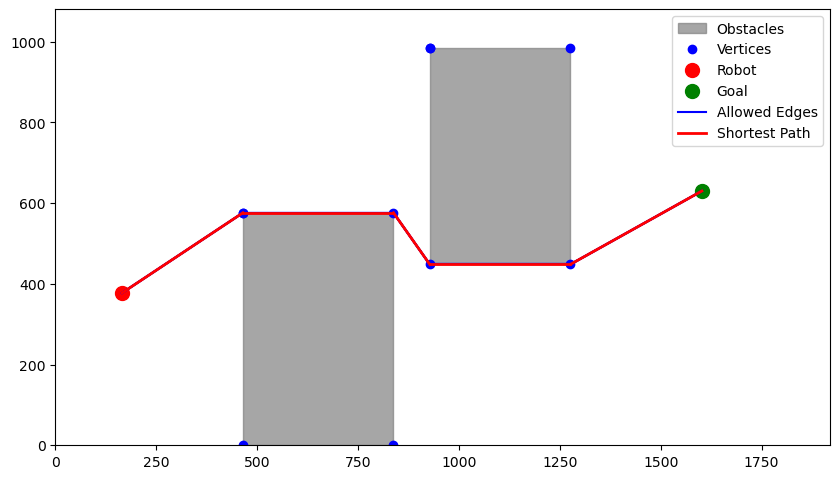

In [8]:
ret, frame = cap.read()

# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal(frame)
robot_centroid, robot_direction = vision.vision_robot(frame)

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot(frame)

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), BOUNDS)

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration: 1
Kalman:  x:  8.0 , y:  20.0 , angle:  1.3045442776439713
Rotation state:
Robot angle:  [1.30454428] , Goal angle:  [0.57430483] , Rotation to achieve:  [-0.73023945]
Iteration: 2
Kalman:  x:  8.0 , y:  20.0 , angle:  1.3045442776439713
Rotation state:
Robot angle:  [1.30454428] , Goal angle:  [0.57430483] , Rotation to achieve:  [-0.73023945]
Iteration: 3
Kalman:  x:  8.008942497564245 , y:  20.032789157735564 , angle:  1.2975164199366644
Rotation state:
Robot angle:  [1.29751642] , Goal angle:  [0.5731838] , Rotation to achieve:  [-0.72433262]
Iteration: 4
Kalman:  x:  8.017839176117407 , y:  20.06795812417804 , angle:  1.2395760103884434
Rotation state:
Robot angle:  [1.23957601] , Goal angle:  [0.57195966] , Rotation to achieve:  [-0.66761635]
Iteration: 5
Kalman:  x:  8.019393899152284 , y:  20.072322645074028 , angle:  1.134675556367073
Rotation state:
Robot angle:  [1.13467556] , Goal angle:  [0.57181959] , Rotation to achieve:  [-0.56285596]
Iteration: 6
Kalman:  x:

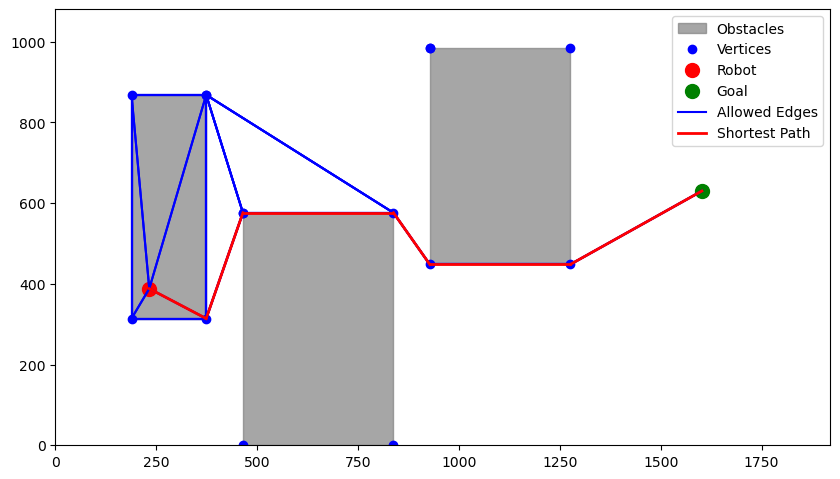

centroid camera:  (12, 20)
glob nav path : [(20, 16), (25, 31), (45, 31), (50, 24), (68, 24), (86, 34)]
Iteration: 23
Kalman:  x:  12.0001043186912 , y:  20.00131105654327 , angle:  0.543855606166997
Rotation state:
Robot angle:  [0.54385561] , Goal angle:  [-0.46378392] , Rotation to achieve:  [-1.00763953]
Iteration: 24
Kalman:  x:  11.78307842891406 , y:  19.87007029054594 , angle:  0.48980197085050614
Rotation state:
Robot angle:  [0.48980197] , Goal angle:  [-0.4401697] , Rotation to achieve:  [-0.92997167]
Iteration: 25
Kalman:  x:  11.579589256952667 , y:  19.761303218684606 , angle:  0.4179575998672211
Rotation state:
Robot angle:  [0.4179576] , Goal angle:  [-0.42009692] , Rotation to achieve:  [-0.83805452]
Iteration: 26
Kalman:  x:  11.480833549474282 , y:  19.717526664783094 , angle:  0.3135092427203018
Rotation state:
Robot angle:  [0.31350924] , Goal angle:  [-0.41146336] , Rotation to achieve:  [-0.72497261]
Iteration: 27
Kalman:  x:  11.438443699698139 , y:  19.70480837

In [ ]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)


old_time = 0.0
iter = 0

while cap.isOpened() == True:
    if iter == 0:
        old_time = time.time()
        
    dt = time.time() - old_time
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter += 1
    print("Iteration:", iter)

    # Check if the robot is arrived at the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        camera_check_enabled = False
        break
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # Prox sensors detect something, we call the local navigation
    if detected:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE
        
    # Measure the wheel's speed and convert it from thymio ref to cm/s and give it to Kalman filter
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    
    print("Kalman: ", "x: ", Kfilter.Mu[0][0], ", y: ", Kfilter.Mu[1][0], ", angle: ", Kfilter.Mu[2][0])
    
    # Robot receive the value from Kalman estimation
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == ROTATION_STATE:
        print("Rotation state:")
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print("Robot angle: ", Kfilter.Mu[2], ", Goal angle: ", 
              np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), 
              ", Rotation to achieve: ", angle)
        
        if angle > 0:
            robot_speed = [SPEED_TURN, -SPEED_TURN]  # counterclockwise
        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]  # clockwise

        if abs(angle) < ROT_ACCURACY:
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue
        
    elif global_state == TRANSLATION_STATE:
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
    elif global_state == CAMERA_STATE:
        print("Camera state:")
        robot_centroid = [0, 0]
        
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            ret, frame = cap.read()
            robot_centroid, robot_direction = vision.vision_robot(frame)
            
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid), BOUNDS)
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("glob nav path :", intermediate_goals)
        
        global_state = ROTATION_STATE
        continue
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("Local avoidance state:")
        
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
    
        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
        
        obstacles.append(Object)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(3)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)
    

    

In [10]:
await stop_robot()       #A RETIRER LORS DU RENDU, CAR NON UTILE